In [5]:
import pandas as pd
import numpy as np
from hyperopt import fmin, tpe, hp, Trials
from tqdm import tqdm
import threading
import random
import time
import gc

# show all columns in pandas
pd.set_option('display.max_columns', None)

<IPython.core.display.Javascript object>

In [6]:
def sum_gain_treated_cases(treated_cases, gain_index=-1):
    sum_gain = {
        'TN': 0,  # True Negative
        'FP': 0,  # False Positive
        'TP': 0,  # True Positive
        'FN': 0,  # False Negative
        'gain': 0
    }

    for case in treated_cases.values():
        actual = case[3]  
        predicted = case[4] 
        gain = case[gain_index]  

        if actual == 0 and predicted == 0:  # True Negative
            sum_gain['TN'] += gain
        elif actual == 0 and predicted == 1:  # False Positive
            sum_gain['FP'] += gain
        elif actual == 1 and predicted == 1:  # True Positive
            sum_gain['TP'] += gain
        elif actual == 1 and predicted == 0:  # False Negative
            sum_gain['FN'] += gain
        
        sum_gain['gain'] += gain

    return sum_gain

def accuracy(tp, tn, fp, fn):
    return (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) != 0 else 0

def precision(tp, fp):
    return tp / (tp + fp) if (tp + fp) != 0 else 0

def recall(tp, fn):
    return tp / (tp + fn) if (tp + fn) != 0 else 0

def f_score(precision, recall):
    return 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0

def auc(tp, fp, fn, tn):
    return tp / (tp + fn) + tn / (tn + fp) if (tp + fn) != 0 and (tn + fp) != 0 else 0

<IPython.core.display.Javascript object>

Results for: bpic2012 log
NoOptimization


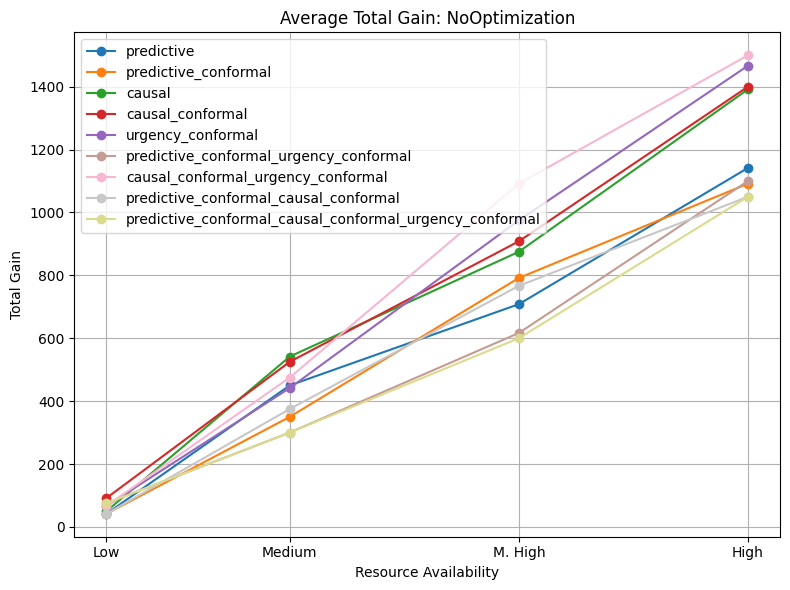

Optimized


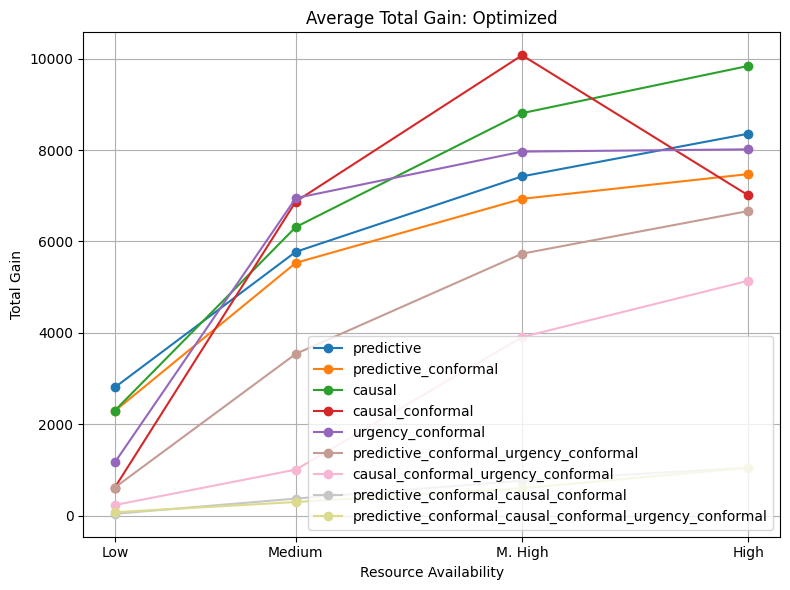

Results for: bpic2017 log
NoOptimization


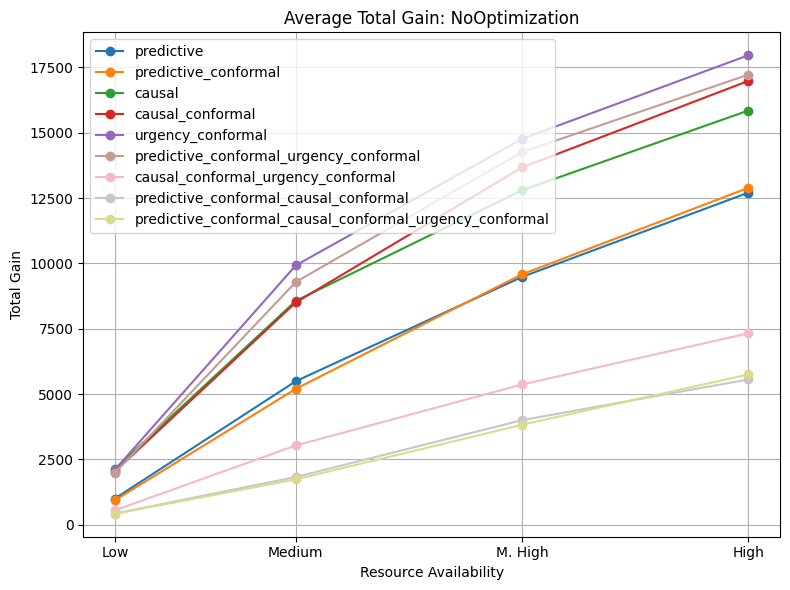

Optimized


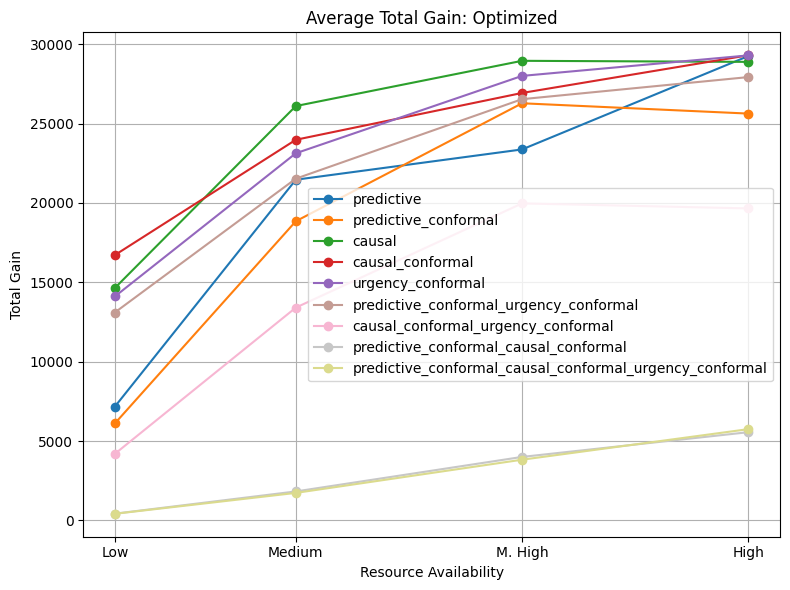

<IPython.core.display.Javascript object>

In [7]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as mtick
from matplotlib.ticker import FuncFormatter

res_utiliz_dict = {}
res_best_param_dict = {}
res_best_trial_dict = {}
time_taken_optimized={}




def load_results(results_directory, results_type, resources_list, log_name, gain_index):
    rules_data = {resource: {} for resource in resources_list}

    

    for resources in resources_list:
        file_path = f"{results_directory}/{results_type}_{resources}_{treatment_duration}_results_dict_all.pkl"
        with open(file_path, "rb") as f:
            results_dict = pickle.load(f)

        if results_type=="Optimized":
            file_path_params = f"{results_directory}/{results_type}_{resources}_{treatment_duration}_best_params.pkl"
            with open(file_path_params, "rb") as f:
                best_param = pickle.load(f)

            file_path_trial = f"{results_directory}/{results_type}_{resources}_{treatment_duration}_best_trial_dict.pkl"
            with open(file_path_trial, "rb") as f:
                best_trial =  pickle.load(f)

            file_path_time = f"{results_directory}/{results_type}_{resources}_{treatment_duration}_time_taken_dict.pkl"
            with open(file_path_time, "rb") as f:
                time_taken = pickle.load(f)


        file_path_time_taken_per_rule = f"{results_directory}/{results_type}_{resources}_{treatment_duration}_time_taken_per_rule.pkl"
        with open(file_path_time_taken_per_rule, "rb") as f:
            time_taken_per_rule = pickle.load(f)       

             

        for rule, treated_cases in results_dict[result_types][log_name].items():
            if results_type=="Optimized":
                res_best_param_dict.setdefault(resources, {})[rule] = best_param[resources][rule]
                res_best_trial_dict.setdefault(resources, {})[rule] = best_trial[resources][rule]
                time_taken_optimized.setdefault(resources, {})[rule] = time_taken[resources][rule]
            total_sum_gain = sum_gain_treated_cases(treated_cases, gain_index)
            rules_data[resources][rule] = {'Total Gain': total_sum_gain['gain']}
            res_utiliz_dict.setdefault(resources, {})[rule] = np.round(get_resource_utilization(treated_cases, 1, resources, time_taken_per_rule[resources][rule]), 2)    
            
    return rules_data


def calculate_average_results(results_directories, result_types, resources_list, log_name, gain_index=-1):
    average_results = {resource: {} for resource in resources_list}

    for results_directory in results_directories:
        rules_data = load_results(results_directory, result_types, resources_list, log_name, gain_index)

        for resource, rules in rules_data.items():
            for rule, metrics in rules.items():
                if rule not in average_results[resource]:
                    average_results[resource][rule] = {'Total Gain': []}
                average_results[resource][rule]['Total Gain'].append(metrics['Total Gain'])

    for resource, rules in average_results.items():
        for rule, metrics in rules.items():
            average_results[resource][rule]['Total Gain'] = np.mean(metrics['Total Gain'])

    return average_results



def plot_average_results(average_results, resources_list, cmap, title, results_dir):
    fig, ax = plt.subplots(figsize=(8, 6))

    rules = list(average_results[resources_list[0]].keys()) 

    for rule in rules:       
        values = [average_results[resource][rule]['Total Gain'] for resource in resources_list]
        color = cmap(rules.index(rule))    
            
        ax.plot(resources_list, values, label=rule, marker='o', color=color)

    xlabels = [ "Low", "Medium", "M. High", 'High']
    ax.set_ylabel('Total Gain')
    ax.grid(True)
    ax.set_xlabel('Resource Availability')
    ax.set_xticks(resources_list)
    ax.set_xticklabels(xlabels)
    ax.legend()

    ax.set_title(title)
    plt.tight_layout()
    plt.savefig(f"{results_dir}/avgAll.pdf")
    plt.savefig(f"{results_dir}/avgAll.png")
    plt.show()





iterations = [1, 2, 3]
logs = ["bpic2012", "bpic2017"]

for log_name in logs:
    print(f"Results for: {log_name} log")

    version = "v1"


    results_directories = [
        f"./results_all_runtime_final_{version}/results_fixed_1/{log_name}/",
        f"./results_all_runtime_final_{version}/results_fixed_2/{log_name}/",
        f"./results_all_runtime_final_{version}/results_fixed_3/{log_name}/"
    ]

    resources_list = [1, 5, 10, 15]
    treatment_duration = 1


    cmap = plt.cm.get_cmap('tab20', 10)

    result_typess = ["NoOptimization", "Optimized"]

    total_gain_ptimized = {}
    total_gain_NoOptimization = {}
    total_gain_all = {"NoOptimization": {}, "Optimized": {}}
    avg_results_ptimized = {}
    avg_results_NoOptimization = {}
    avg_results_all = {"NoOptimization": {}, "Optimized": {}}


    for result_types in result_typess:
        print(result_types)
        results_dir = f"./plots_runtime_{version}/{log_name}/{result_types}/"
        import os
        if not os.path.exists(os.path.join(results_dir)):
            os.makedirs(os.path.join(results_dir))

        average_results = calculate_average_results(results_directories, result_types, resources_list, log_name, gain_index=-1)    
        total_gain_all[result_types]=average_results
        plot_average_results(average_results, resources_list, cmap, 'Average Total Gain: '+result_types, results_dir)
